In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2153 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)  # 

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 0 0 1 0 2 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


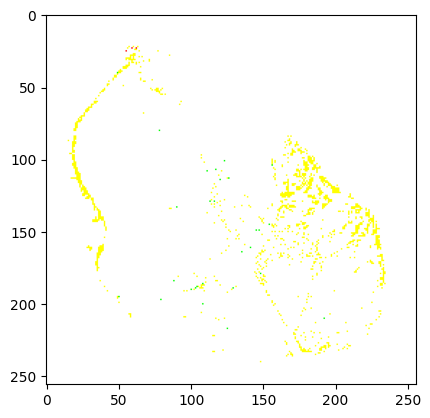

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy())
    print(image_batch[0].shape)
   

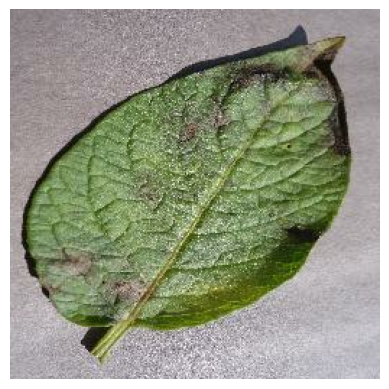

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[2].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
#80% ==> training
#20% ==> 10% validation, 10% testing

SyntaxError: invalid syntax (928503444.py, line 1)

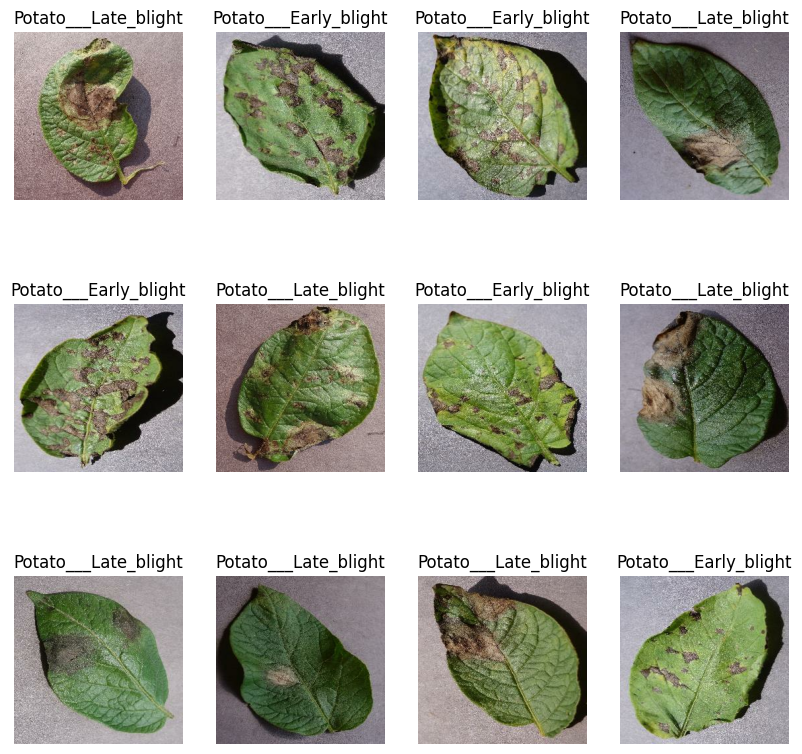

In [94]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
training_size = 0.8  # 80%
len(dataset)*training_size


In [ ]:
dataset.take(54)

In [11]:
train_ds = dataset.take(54)  
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1              # validation data set
len(dataset)*val_size


6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split == 1)
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [22]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
# data augmentation layer will rotate the image in four different angles 
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
# READY TO BUILD A MODEL NOW
# We are going to use convolutional neural network

In [25]:
BATCH_SIZE, IMAGE_SIZE

(32, 256)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
        
])
model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 238ms/step - loss: 1.1027 - accuracy: 0.2344


In [30]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 62s 1s/step - loss: 0.8866 - accuracy: 0.5519 - val_loss: 0.7133 - val_accuracy: 0.7292
Epoch 2/50
54/54 [==============================] - 53s 972ms/step - loss: 0.5824 - accuracy: 0.7507 - val_loss: 0.5854 - val_accuracy: 0.7552
Epoch 3/50
54/54 [==============================] - 49s 907ms/step - loss: 0.3466 - accuracy: 0.8569 - val_loss: 0.4970 - val_accuracy: 0.7552
Epoch 4/50
54/54 [==============================] - 49s 902ms/step - loss: 0.2875 - accuracy: 0.8874 - val_loss: 0.2042 - val_accuracy: 0.9323
Epoch 5/50
54/54 [==============================] - 49s 908ms/step - loss: 0.2475 - accuracy: 0.9073 - val_loss: 0.2163 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 49s 905ms/step - loss: 0.2399 - accuracy: 0.8979 - val_loss: 0.2577 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 49s 903ms/step - loss: 0.2212 - accuracy: 0.9155 - val_loss: 0.1785 - val_accuracy: 0.9427
Ep

In [31]:
scores

[1.1027172803878784, 0.234375]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
len(history.history['loss'])

50

In [36]:
len(history.history['accuracy'])

50

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [38]:
history.history['accuracy']

[0.551906168460846,
 0.7507331371307373,
 0.8568915128707886,
 0.8873900175094604,
 0.9073314070701599,
 0.8979471921920776,
 0.9155425429344177,
 0.9307917952537537,
 0.9255132079124451,
 0.9343108534812927,
 0.9378299117088318,
 0.9472140669822693,
 0.9489735960960388,
 0.9589442610740662,
 0.9307917952537537,
 0.9495601058006287,
 0.9618768095970154,
 0.9513196349143982,
 0.9630498290061951,
 0.9683284163475037,
 0.9677419066429138,
 0.9718475341796875,
 0.9583577513694763,
 0.9636363387107849,
 0.9759531021118164,
 0.9730205535888672,
 0.9771261215209961,
 0.9724340438842773,
 0.9648093581199646,
 0.9771261215209961,
 0.9894428253173828,
 0.9724340438842773,
 0.9800586700439453,
 0.9818181991577148,
 0.9753665924072266,
 0.9642228484153748,
 0.9741935729980469,
 0.9835777282714844,
 0.9824047088623047,
 0.9782991409301758,
 0.9935483932495117,
 0.9917888641357422,
 0.9935483932495117,
 0.9782991409301758,
 0.9759531021118164,
 0.9935483932495117,
 0.9929618835449219,
 0.98533725738

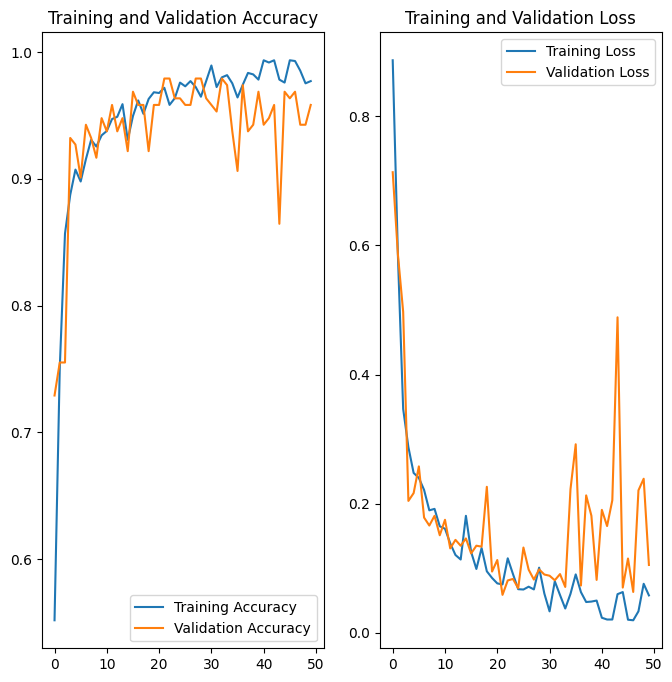

In [39]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc,label='Validation Accuracy' )
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
import numpy as np


first image to predict 
first image actual label: Potato___Late_blight
1/1 [==============================] - 0s 497ms/step
predicted label: Potato___Late_blight


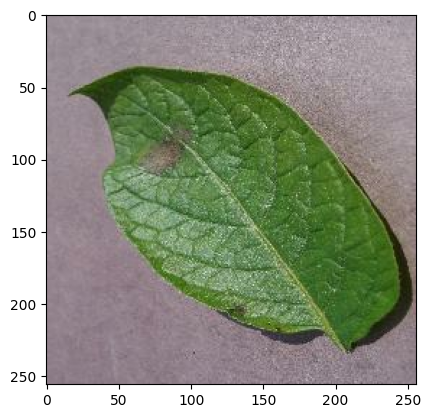

In [96]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()

    print("first image to predict ")
    plt.imshow(first_image)
    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [62]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


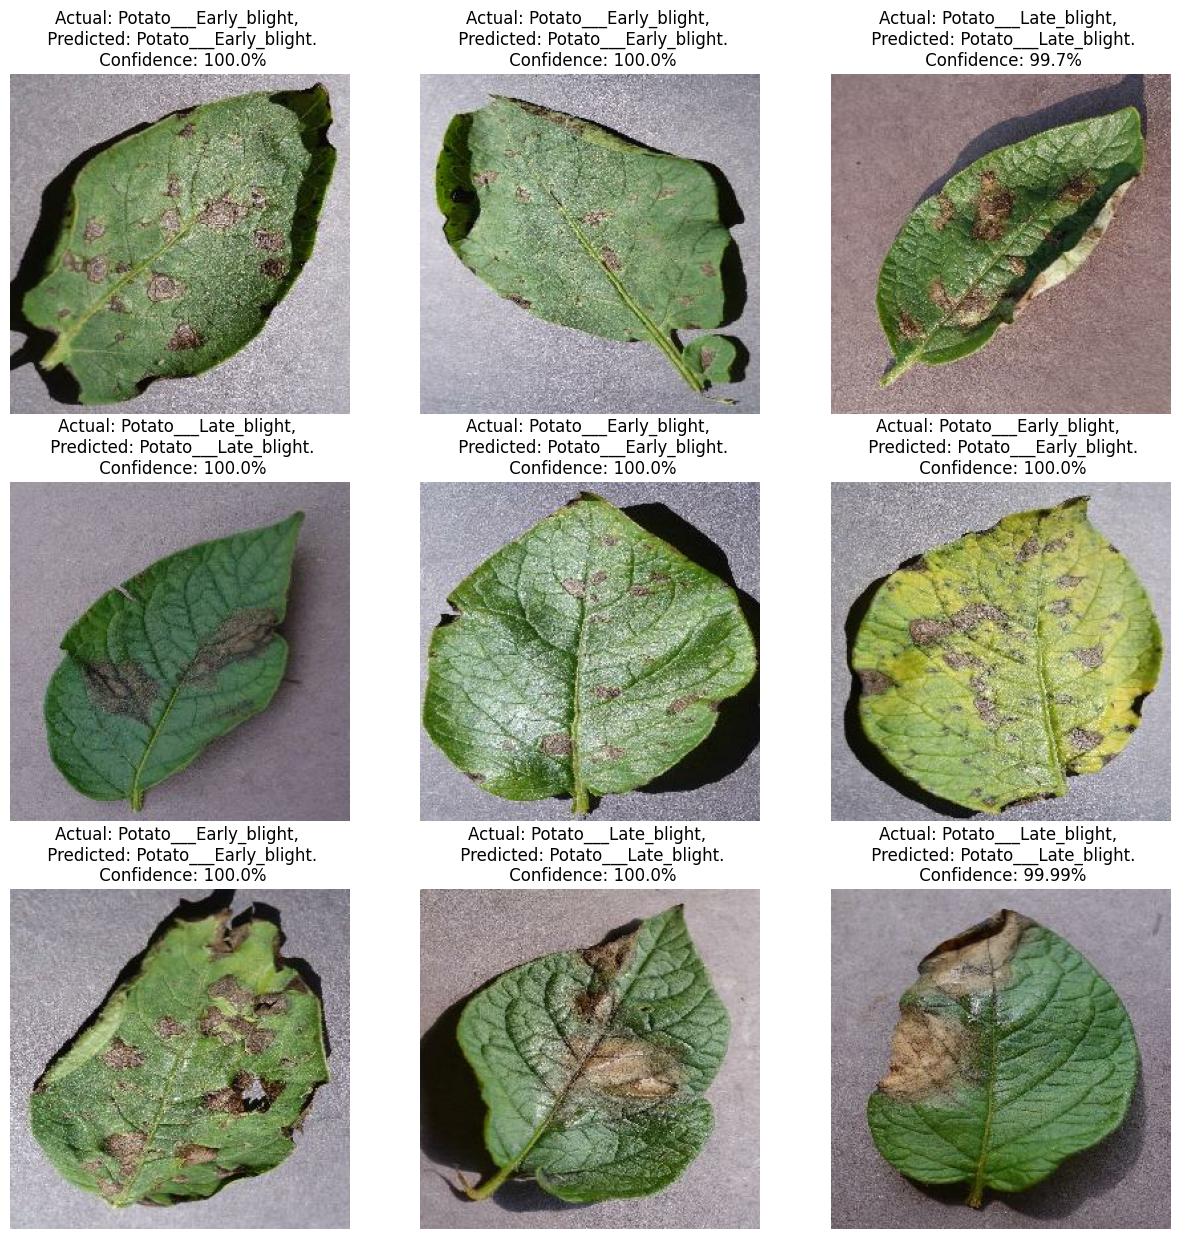

In [43]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
#Export model to a file on disk
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [45]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [46]:
print(tf.__version__)


2.10.0
